In [108]:
import numpy as np
import pandas as pd
import skimage.io as sio
import matplotlib.pyplot as plt
import skimage
from skimage.morphology import square, opening, closing, skeletonize
from skimage.measure import regionprops, label
from skan import csr, draw

from skimage.filters import roberts, sobel, scharr, prewitt, median, rank
from skimage import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk, reconstruction, remove_small_objects
from skimage.exposure import equalize_hist
from skimage.measure import regionprops, label

import diff_classifier.aws as aws
import diff_register.register as reg
import diff_register.im_process as imp

In [2]:
imprefix = 'mGluR5326_5_Iba1488_slice3_10x_scan'
folder = 'I:/Mengying/Confocal/20181018 mGluR5326 328 QD in vivo'
imfilename = '{}/{}.tif'.format(folder, imprefix)
#aws.download_s3('{}/{}'.format(folder, imfilename), imfilename, bucket_name='ccurtis.data')

In [3]:
rawim = sio.imread(imfilename)

In [55]:
xr = (500,700)
yr = (500,700)
cellim = rawim[0, :, :]
qdotim = rawim[1, :, :]
invim = (256**2 - cellim[xr[0]:xr[1], yr[0]:yr[1]]).astype('uint16')
smallim = cellim[xr[0]:xr[1], yr[0]:yr[1]]
qsmallim = qdotim[xr[0]:xr[1], yr[0]:yr[1]]

In [ ]:
sio.imsave('large_image.tif', cellim)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,12))
axes[0].imshow(cellim, cmap='gray', vmax=5*cellim.mean())
axes[1].imshow(qdotim, cmap='gray', vmax=5*qdotim.mean())
for ax in axes:
    ax.axis('off')

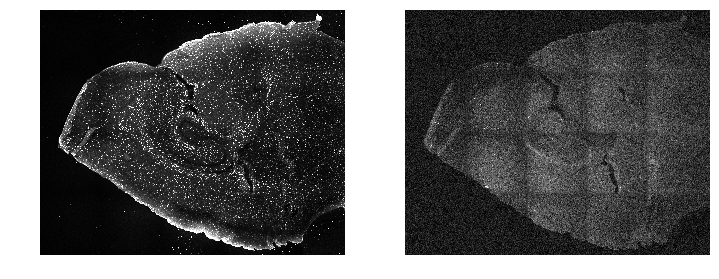

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(12,12))
axes[0].imshow(cellim, cmap='gray', vmax=5*cellim.mean())
axes[1].imshow(qdotim, cmap='gray', vmax=5*qdotim.mean())
for ax in axes:
    ax.axis('off')

In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(12,12))
axes.imshow(invim, cmap='gray', vmax=1.1*invim.mean())

c:\users\enuser\anaconda3\lib\site-packages\skimage\filters\rank\generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


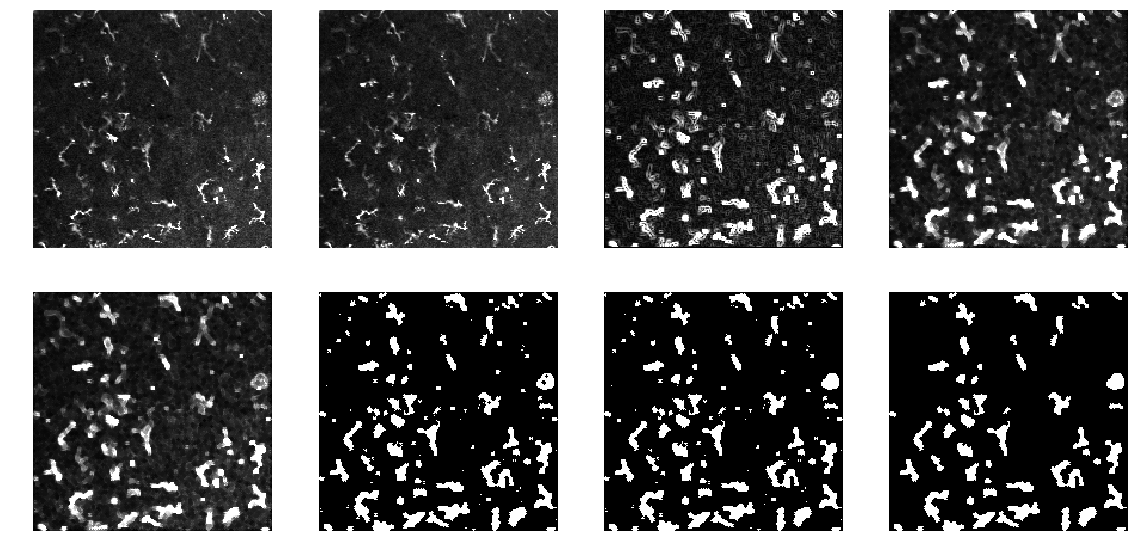

In [105]:
stophim = binary_BF(smallim, meanse=disk(0), closese=disk(1), opense=disk(0), bi_thresh=1.4, min_size=16)

c:\users\enuser\anaconda3\lib\site-packages\skimage\filters\rank\generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


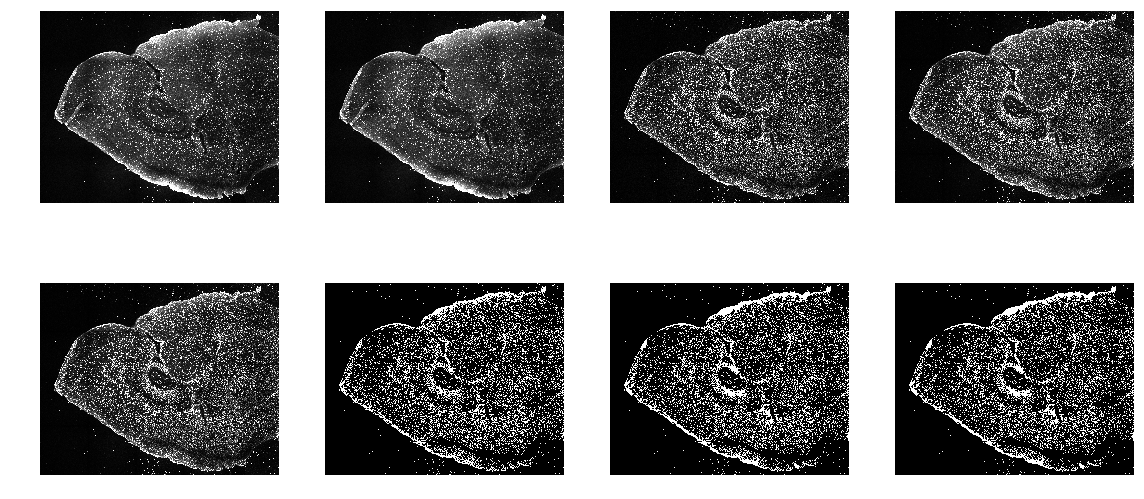

In [70]:
tophim = binary_BF(cellim, meanse=disk(0), closese=disk(1), opense=disk(0), bi_thresh=1.4, min_size=16)

In [71]:
incellim = qdotim * tophim

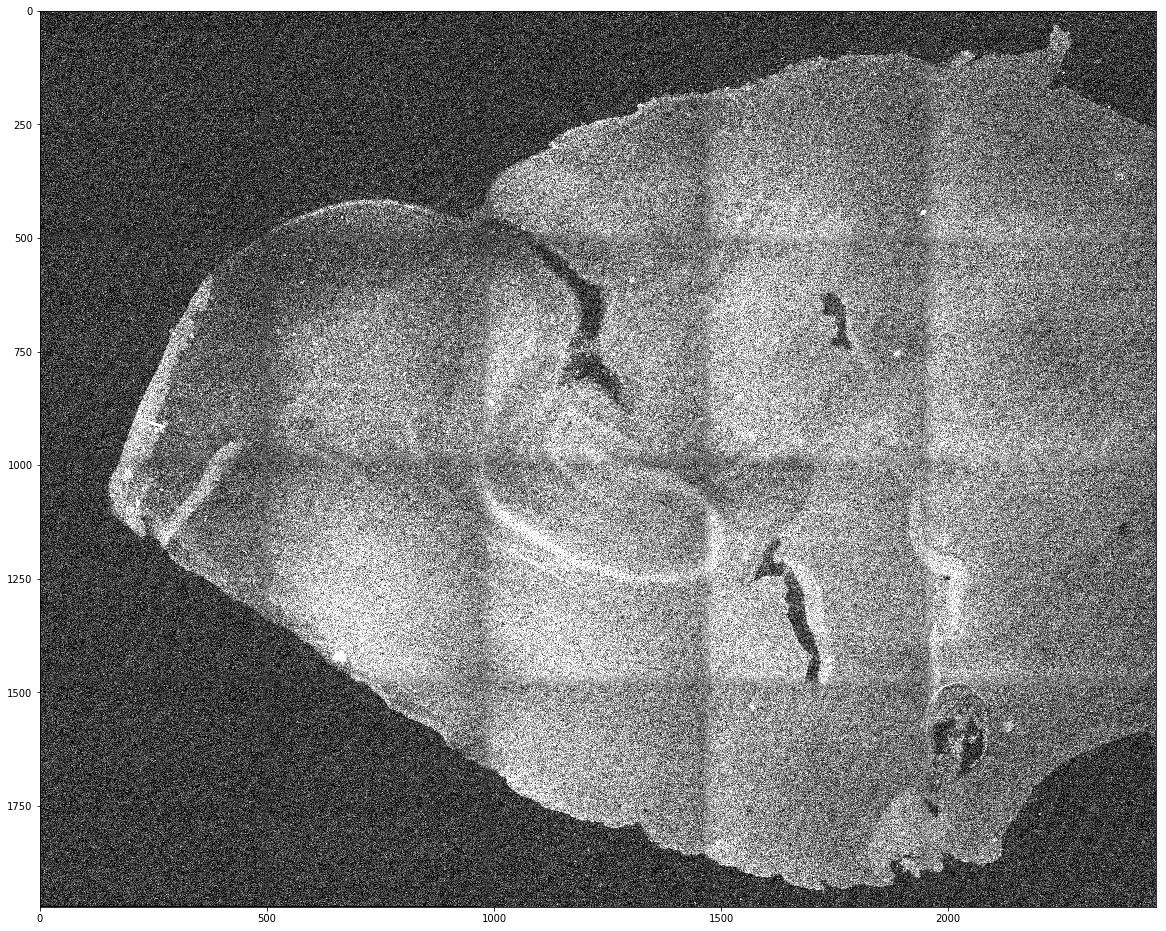

In [126]:
fig = plt.figure(figsize=(20,20))
plt.imshow(qdotim, cmap='gray', vmax=10*np.mean(incellim))

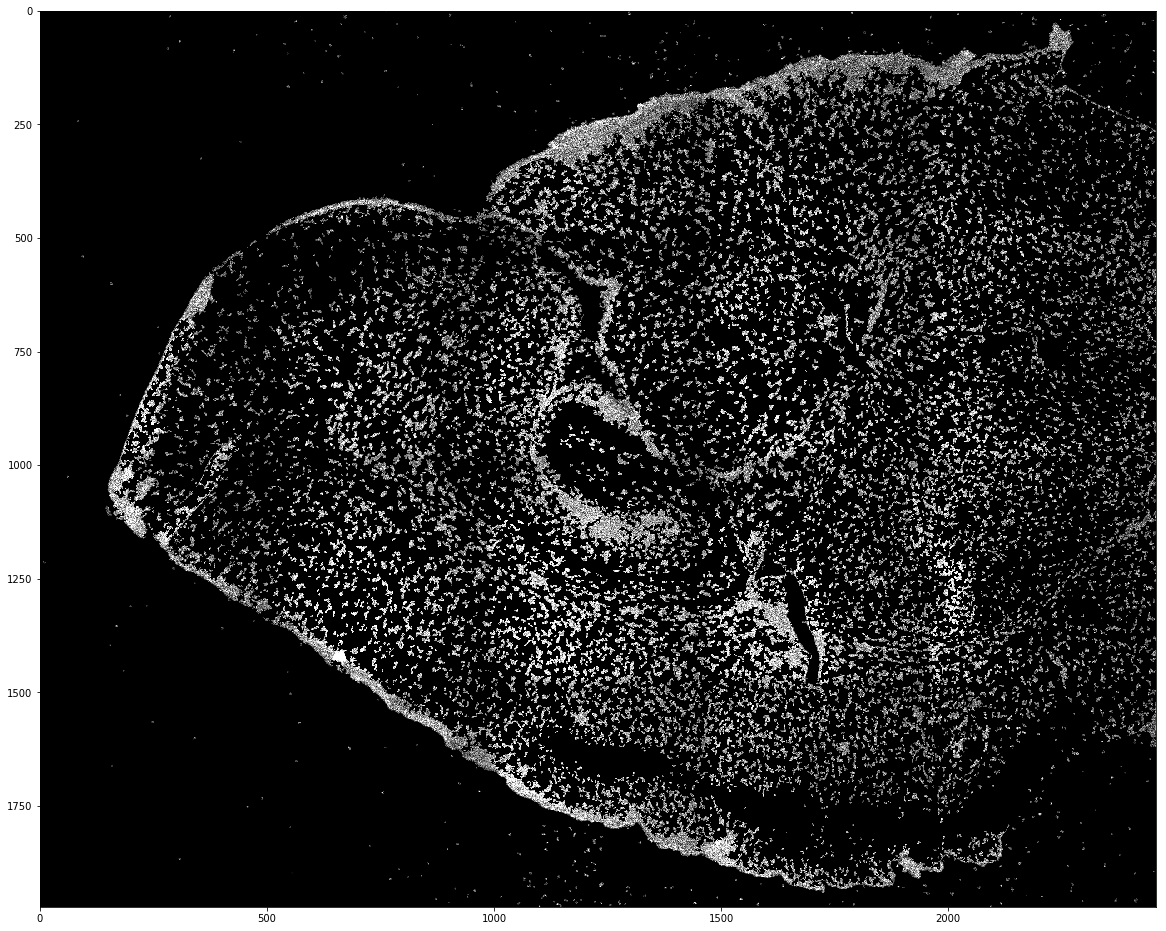

In [125]:
fig = plt.figure(figsize=(20,20))
plt.imshow(incellim, cmap='gray', vmax=10*np.mean(incellim))

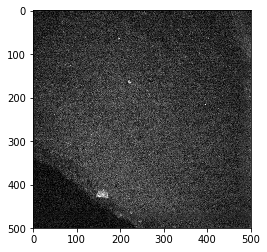

In [78]:
xr = (1000,1500)
yr=(500,1000)
plt.imshow(qdotim[xr[0]:xr[1], yr[0]:yr[1]], cmap='gray', vmax=30*np.mean(incellim))

In [112]:
props = regionprops(label(tophim), intensity_image=qdotim)

In [113]:
mean_int = []
area = []
tot_int = []
for prop in props:
    mean_int.append(prop.mean_intensity)
    area.append(prop.area)
    tot_int.append(prop.area*prop.mean_intensity)
propertiesd = {'Mean_Intensity': mean_int,
               'Area': area,
              'Total_Intensity': tot_int}
properties = pd.DataFrame(propertiesd)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000211F0278>]],
      dtype=object)

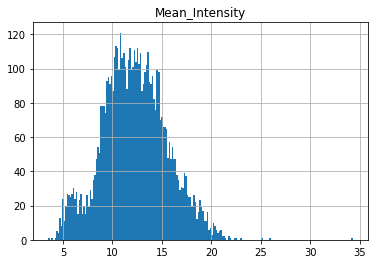

In [117]:
properties.hist('Mean_Intensity', bins=200)

(0, 1000)

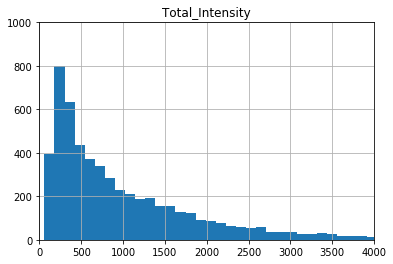

In [123]:
properties.hist('Total_Intensity', bins=6000)
plt.xlim([0, 4000])
plt.ylim([0, 1000])

In [49]:
def binary_BF(image, meanse=disk(10), edgefilt='prewitt', opense=disk(10),
              closese=disk(10), fill_first=False, bi_thresh=0.000025,
              min_size=10):
    
    #convertim = img_as_ubyte(image)
    meanim = rank.mean(image, meanse)
    if edgefilt is 'prewitt':
        edgeim = prewitt(meanim)
    elif edgefilt is 'sobel':
        edgeim = sobel(meanim)
    elif edgefilt is 'scharr':
        edgeim = scharr(meanim)
    elif edgefilt is 'roberts':
        edgeim = roberts(meanim)
    
    closeim = closing(edgeim, closese)
    openim = opening(closeim, opense)
    if fill_first:
        seed = np.copy(openim)
        seed[1:-1, 1:-1] = openim.max()
        mask = openim
        filledim = reconstruction(seed, mask, method='erosion')
        binarim = filledim > bi_thresh
    else:
        binarim = openim > bi_thresh*np.mean(openim)
        seed = np.copy(binarim)
        seed[1:-1, 1:-1] = binarim.max()
        mask = binarim
        filledim = reconstruction(seed, mask, method='erosion') > 0.5

    #tophim = filledim - closing(white_tophat(filledim, tophatse), opense)>0.01
    tophim = remove_small_objects(filledim, min_size=min_size)
    
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
    ax[0][0].imshow(image, cmap='gray', vmax=4*np.mean(image))
    ax[0][1].imshow(meanim, cmap='gray', vmax=4*np.mean(meanim))
    ax[0][2].imshow(edgeim, cmap='gray', vmax=4*np.mean(edgeim))
    ax[0][3].imshow(closeim, cmap='gray', vmax=4*np.mean(closeim))
    ax[1][0].imshow(openim, cmap='gray', vmax=4*np.mean(openim))
    ax[1][1].imshow(binarim, cmap='gray')
    ax[1][2].imshow(filledim, cmap='gray')
    ax[1][3].imshow(tophim, cmap='gray')
    for axes in ax:
        for axe in axes:
            axe.axis('off')
    fig.tight_layout()
    
    return tophim

In [ ]:
filled